Downloanding third-party code

In [1]:
# !wget https://raw.githubusercontent.com/akamaster/pytorch_resnet_cifar10/d1872999394aa0c234e8d855e3c853eb061f7c06/resnet.py


Template for downloading/uploading.
Because I used not cloud PC for cifar100 experiments, it has only 'pass'

In [1]:
def download_model(source_name, saving_name):
    pass

def upload_model(source_name, saving_name):
    pass

def upload_logs():
    pass

Libs importing

In [3]:
import gc
import os
import datetime

import numpy as np
np.random.seed(42)

import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils as utils
from torch.utils.data import Subset, ConcatDataset, DataLoader

from tqdm import tqdm_notebook as tqdm
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorboard.plugins.hparams import api as hp
from sklearn.metrics import accuracy_score

from resnet import BasicBlock, _weights_init

Models declaration

In [5]:
class ResNetModified(nn.Module):
    def __init__(self, block, num_blocks, input_channels, num_classes=10):
        super(ResNetModified, self).__init__()
        self.in_planes = 16

        self.conv1 = nn.Conv2d(input_channels, 16, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(16)
        self.layer1 = self._make_layer(block, 16, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 32, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 64, num_blocks[2], stride=2)
        self.linear = nn.Linear(64, num_classes)

        self.apply(_weights_init)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion

        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = F.avg_pool2d(out, out.size()[3])
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out

In [6]:
def resnet7():return ResNetModified(BasicBlock, [1, 1, 1], 3, 100)
def resnet20():return ResNetModified(BasicBlock, [3, 3, 3], 3, 100)
def resnet32():return ResNetModified(BasicBlock, [5, 5, 5], 3, 100)

Declaration of utils 

In [7]:
class AverageMeter:
  """Class for computing average values
  """    
  def __init__(self):
    """Init class
    """      
    self.sum_ = 0
    self.count = 0
  
  def update(self, val, count=1):
    """Add new value to track
    
    Arguments:
        val {float} -- new value
    
    Keyword Arguments:
        count {int} -- weigth of val (default: {1})
    """      
    self.sum_ += val
    self.count += count

  def average(self):
    """return average value for given values
    """      
    return self.sum_ / self.count

In [8]:
class TensorBoardLogger:
    """Class for logging into TensorBoard
    """    
    def __init__(self, log_dir, dataset, net, experiment_name):
        """Init logger
        
        Arguments:
            log_dir {string} -- log dir
            dataset {string} -- name of dataset
            experiment_name {string} -- name of experiment
        """        
        current_time = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
        log_dir_full = os.path.join(log_dir, dataset, net, experiment_name, current_time)
        self.writer = tf.summary.create_file_writer(log_dir_full)
        self.step_ = 0
        
    def log_scalar(self, tag, value, step=None, description=None):
        """Log scalar
        
        Arguments:
            tag {string} -- name of variable to log
            value {float} -- value of variable
        
        Keyword Arguments:
            step {int} -- current epoch number (default: {None})
            description {string} -- [description] (default: {None})
        """        
        if step is None:
            step = self.step_
        with self.writer.as_default():
            tf.summary.scalar(tag, value, step=step, description=description)
            
    def step(self):
        """Increase epoch number by 1
        """        
        self.step_+=1

    def log_hparams(self, hparams):
        """log hparams
        
        Arguments:
            hparams {dict} -- dict to log
        """      
        with self.writer.as_default():
            hp.hparams(hparams)
        

Dataset declaration

In [6]:
batch_size = 64
dataset_name = "cifar100"


In [5]:
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225])

# augmentation and normalization for training
transform_train = transforms.Compose(
    [
     transforms.RandomHorizontalFlip(p=0.5),
     transforms.RandomCrop(32, 4),
     transforms.ToTensor(),
     normalize
     ])

# only normalization for testing
transform_test = transforms.Compose(
    [
     transforms.ToTensor(),
     normalize
     ])

trainset = torchvision.datasets.CIFAR100(root='./data', train=True,
                                        download=True, transform=transform_train)
valset = torchvision.datasets.CIFAR100(root='./data', train=True,
                                        download=True, transform=transform_test)
# split trainvalset into val and train
idx = np.arange(len(trainset))
split = int(len(trainset)*0.15)
np.random.seed(42) # set seed to reproduce given set
np.random.shuffle(idx)
train_idx = idx[split:]
val_idx = idx[:split]

trainset = Subset(trainset, train_idx)
valset = Subset(valset, val_idx)


trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2,
                                          pin_memory=True, 
                                          )
valloader = torch.utils.data.DataLoader(valset, batch_size=batch_size,
                                          shuffle=True, num_workers=2,
                                          pin_memory=True, 
                                          )

testset = torchvision.datasets.CIFAR100(root='./data', train=False,
                                       download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2,
                                         pin_memory=True, )

Files already downloaded and verified
Files already downloaded and verified


W0315 16:46:57.928970 140201449768768 image.py:700] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


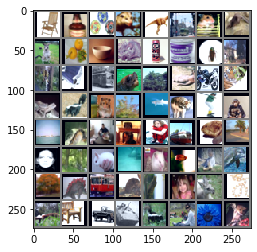

In [9]:
def imshow(img):
    img = img / 4 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))

In [11]:
# check the first index, to check that trainval set splitted correctly
assert val_idx[0]==33553, "invalid val set" 

Training functions definition

In [12]:
def accuracy_minibatch(outputs, labels):
  """Compute accuracy for batch
  
  Arguments:
      outputs {list or np.array or torch.Tensor} -- outputs from model (vectors of probabilities)
      labels {list or np.array or torch.Tensor} -- labels (one number for each sample)
  
  Returns:
      float -- accuracy for minibatch
  """  
  if isinstance(outputs, torch.Tensor):
    outputs = outputs.cpu().detach().numpy()
  if isinstance(labels, torch.Tensor):
    labels = labels.cpu().detach().numpy()
  
  predict_= np.argmax(outputs, axis=1)
  true_labels_= labels
  micro_acc_score = accuracy_score(predict_, true_labels_)
  return micro_acc_score

In [13]:
def validate(net, testloader, logger=None, compression_f=None, verbose=True, prename="val"):
  """Function for compute metrics on validation set
  
  Arguments:
      net {torch net} -- model
      testloader {DataLoader} -- set to validation
      
  Keyword Arguments:
      logger {TensorBoardLogger} -- logger (default: {None})
      compression_f {function} -- function to preprocess input (default: {None})
      verbose {bool} -- show metrics (default: {True})
      prename {string} -- prename to name of metric (default: {"val"})
  
  Returns:
      [floats] -- scores for computing metrics
  """  
  # change net to evaluation mode
  net.eval()
  ce_loss_avg = AverageMeter()
  accuracy_score_avg = AverageMeter()
  criterion = nn.CrossEntropyLoss()
  
  # evaluate dataset
  for i, data in enumerate(testloader, 0):
    inputs, labels = data
    inputs, labels = inputs.cuda(), labels.cuda()
    current_batch_size = len(labels)

    if compression_f is not None:
      inputs = compression_f(inputs)
    outputs = net(inputs)
    loss = criterion(outputs, labels).cpu().detach().numpy()
    
    micro_acc_score = accuracy_minibatch(outputs, labels)

    accuracy_score_avg.update(micro_acc_score*current_batch_size, current_batch_size)
    ce_loss_avg.update(loss.item()*current_batch_size, current_batch_size)

  accuracy = accuracy_score_avg.average()
  ce_loss = ce_loss_avg.average()
  scores = {
      "%s_accuracy"%prename: accuracy,
      "%s_overall_loss"%prename: ce_loss,
       }
  
  # log scores
  for name, score in scores.items():
    if logger:
      logger.log_scalar(name, score)
    if verbose:
      print(name, score)
  
  if verbose:
    print("__________________")
  # change net to training mode
  net.train()
  return scores

In [18]:
def train_distillation(
    net_teacher, 
    net_student, 
    trainloader, 
    testloader, 
    logger=None,
    compression_f=None, 
    epoches=150,
    verbose=True, 
    return_best=False,
    init_lr=0.1,
    alpha=0.8,
    cos_alpha=0.0,
    l_alpha=0.0,
    p=2,
    temperature=1
    ):
  """Training using knowledge distillation approach
  
  Arguments:
      net_teacher {torch model} -- teacher model
      net_student {torch model} -- student model
      trainloader {DataLoader} -- train set
      testloader {DataLoader} -- test set
  
  Keyword Arguments:
      logger {TensorBoardLogger} -- logger (default: {None})
      compression_f {function} -- function to preprocess input (default: {None})
      epoches {int} -- epochs to train (default: {150})
      verbose {bool} -- show metrics (default: {True})
      return_best {bool} -- return best model (default: {False})
      init_lr {float} -- initial learning rate (default: {0.1})
      alpha {float} -- coefficeint of combining distillation and classical loss (default: {0.8})
      cos_alpha {float} -- coefficeint of cosine disimilarity loss in distillation loss(default: {0.0})
      temperature {int} -- temperature (default: {1})
      l_alpha {float} -- coefficeint of L^p loss in distillation loss (default: {0.0})
      p {int} -- parametr for L^p loss (default: {2})
  
  Returns:
      torch model -- best or last model
  """  
  # change net to training mode
  net_student.train()
  net_teacher.eval()
  # use gpu to train
  net_student.cuda()

  criterion_ce = nn.CrossEntropyLoss().cuda()
  criterion_nll = nn.NLLLoss().cuda()
  criterion_bce = nn.BCELoss().cuda() 
  criterion_kl = nn.KLDivLoss(reduction="batchmean").cuda()
  cosine_similarity = nn.CosineSimilarity(dim=1, eps=1e-6)

  optimizer = torch.optim.SGD(
      net_student.parameters(), 
      lr=init_lr,
      momentum=0.9,
      weight_decay=1e-4)
  scheduler = optim.lr_scheduler.MultiStepLR(optimizer, [80, 105, 125, 140])

  validation_scores = []
  os.makedirs("models", exist_ok=True)
  saving_path_template = "models/model_epoch%s.dms"

  for epoch in range(epoches):  # loop over the dataset multiple times
    saving_name = saving_path_template%epoch
    
    loss_avg = AverageMeter()
    accuracy_score_avg = AverageMeter()
    loss_kl_avg = AverageMeter()
    loss_cos_dis_avg = AverageMeter()
    loss_ce_avg = AverageMeter()

    for i, data in enumerate(trainloader, 1):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        current_batch_size = len(labels)
        inputs, labels = inputs.cuda(), labels.cuda()
        # for supervision transfer
        if compression_f:
          inputs_compressed = compression_f(inputs).detach()
        else:
          inputs_compressed = inputs
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        out_student = net_student(inputs_compressed)
        out_teacher = net_teacher(inputs)

        soft_log_probs = F.log_softmax(out_student / temperature, dim=1)

        soft_output = F.softmax(out_student / temperature, dim=1)

        soft_targets = F.softmax(out_teacher / temperature, dim=1)
        
        loss_ce = criterion_ce(out_student, labels)
        # loss_bce = criterion_bce(soft_output, soft_targets.detach())
        kl_loss = criterion_kl(soft_log_probs, soft_targets.detach())
        cos_dis_loss =  (1 - cosine_similarity(out_student - torch.mean(out_student, dim=1, keepdim=True), out_teacher.detach() - torch.mean(out_teacher.detach(), dim=1, keepdim=True))).mean()
        
        
        l_loss = (torch.abs(out_student - out_teacher)**p).mean()**(1/p)

        loss = (1 - cos_alpha - l_alpha) * kl_loss + cos_alpha * cos_dis_loss + l_alpha * l_loss
        loss.backward()
        optimizer.step()
      
        micro_acc_score = accuracy_minibatch(out_student, labels)

        loss_avg.update(loss.item()*current_batch_size, current_batch_size)
        accuracy_score_avg.update(micro_acc_score*current_batch_size, current_batch_size)
        loss_kl_avg.update(kl_loss.item()*current_batch_size, current_batch_size)
        loss_cos_dis_avg.update(cos_dis_loss.item()*current_batch_size, current_batch_size)
        loss_ce_avg.update(loss_ce.item()*current_batch_size, current_batch_size)

    if verbose:
        print(saving_name)
        print('overall loss {:.3}'.format(loss_avg.average()))
        print('loss kl {:.3}'.format(loss_kl_avg.average()))
        print('loss cos dis {:.3}'.format(loss_cos_dis_avg.average()))
        print('loss ce {:.3}'.format(loss_ce_avg.average()))
        print('current lr {:.3e}'.format(optimizer.param_groups[0]['lr']))
        print("__________________")
    # clear memory 
    gc.collect()
    torch.cuda.empty_cache()  
    
    # save scores to take best model in the future
    validation_score = validate(net_student, valloader, 
                                logger=logger, 
                                verbose=verbose, 
                                compression_f=compression_f)
    accuracy = validation_score['val_accuracy']
    validation_scores.append(accuracy)
    # save model
    torch.save(net_student.state_dict(), saving_name)

    if logger:
        logger.log_scalar("overall_loss", loss_avg.average())
        logger.log_scalar("accuracy", accuracy_score_avg.average())
        logger.log_scalar("kl_loss", loss_kl_avg.average())
        logger.log_scalar("cos_dis_loss", loss_cos_dis_avg.average())
        logger.log_scalar("ce_loss", loss_ce_avg.average())
        logger.step()
    # scheduler.step(loss_avg.average())
    scheduler.step()
    
  best_epoch = np.argmax(validation_scores)
  if return_best:
    choosen_epoch = best_epoch
  else:
    choosen_epoch = epoch
  if verbose:
    print("choosen epoch:", choosen_epoch, ", score:", validation_scores[choosen_epoch])
    print("best epoch:", best_epoch, ", score:", validation_scores[best_epoch])
  model_name = saving_path_template%choosen_epoch
  net_student.load_state_dict(torch.load(model_name))
  return net_student

Training

In [19]:
for net_teacher, teacher_name, alpha, corr_alpha, l_alpha, exp_prename in [
    (resnet20(), "resnet20_classic.pt", 1.0, 0.0, 0.0, "kl"),
    (resnet20(), "resnet20_classic.pt", 1.0, 0.0, 1.0, "rmse"),
    (resnet20(), "resnet20_classic.pt", 1.0, 0.0, 0.5, "rmse_kl"), 
    (resnet20(), "resnet20_classic.pt", 1.0, 1.0, 0.0, "corr"), 
    
    (resnet32(), "resnet32_classic.pt", 1.0, 0.0, 0.0, "kl"),
    (resnet32(), "resnet32_classic.pt", 1.0, 0.0, 1.0, "rmse"),
    (resnet32(), "resnet32_classic.pt", 1.0, 0.0, 0.5, "rmse_kl"), 
    (resnet32(), "resnet32_classic.pt", 1.0, 1.0, 0.0, "corr"), 
                  ]:
  download_model(teacher_name, teacher_name)
  state_dict = torch.load(teacher_name)
  net_teacher.cuda().load_state_dict(state_dict)
  net_student = resnet7().cuda()
  experiment_name = "distillation_"+teacher_name[:-10]+exp_prename+".pt"
  save_name = "resnet7_"+experiment_name
  logger = TensorBoardLogger("logs", dataset_name,  "resnet7", experiment_name)
  net_student = train_distillation(net_teacher, net_student, 
                                   trainloader, valloader, 
                                   logger=logger, return_best=True,
                                   alpha=alpha, 
                                   cos_alpha=corr_alpha, 
                                   l_alpha=l_alpha,
                                   epoches=150)
  print("-----------------")
  print("*****************")
  print(experiment_name)
  score_test = validate(net_student, testloader, prename='test')
  score_val = validate(net_student, valloader, prename='val')
  validate(net_student, trainloader, prename='train')
  print("----------------")
  print("teacher")
  score_teacher_test = validate(net_teacher, testloader, prename='test')
  score_teacher_val = validate(net_teacher, valloader, prename='val')
  validate(net_teacher, trainloader, prename='train')
  print("----------------")
  hparams = {"experiment_name":experiment_name, "teacher":teacher_name, "dataset":dataset_name, "correllation":corr_alpha, "alpha":alpha}
  for key, value in score_val.items():
    hparams["student/"+key] = value
  for key, value in score_test.items():
    hparams["student/"+key] = value
  for key, value in score_teacher_test.items():
    hparams["teacher/"+key] = value
  for key, value in score_teacher_val.items():
    hparams["teacher/"+key] = value
  logger.log_hparams(hparams) 
  torch.save(net_student.state_dict(), save_name)
  upload_model(save_name, save_name)
  upload_logs()

models/model_epoch0.dms
overall loss 3.03
loss kl 3.03
loss cos dis 0.565
loss ce 3.86
current lr 1.000e-01
__________________
val_accuracy 0.1504
val_overall_loss 3.5570072177886964
__________________
models/model_epoch1.dms
overall loss 2.39
loss kl 2.39
loss cos dis 0.413
loss ce 3.23
current lr 1.000e-01
__________________
val_accuracy 0.21213333333333334
val_overall_loss 3.2540946666717527
__________________
models/model_epoch2.dms
overall loss 2.01
loss kl 2.01
loss cos dis 0.348
loss ce 2.85
current lr 1.000e-01
__________________
val_accuracy 0.21133333333333335
val_overall_loss 3.6608192057291666
__________________
models/model_epoch3.dms
overall loss 1.77
loss kl 1.77
loss cos dis 0.311
loss ce 2.6
current lr 1.000e-01
__________________
val_accuracy 0.3288
val_overall_loss 2.6927014074961346
__________________
models/model_epoch4.dms
overall loss 1.6
loss kl 1.6
loss cos dis 0.29
loss ce 2.42
current lr 1.000e-01
__________________
val_accuracy 0.3476
val_overall_loss 2.5755

val_accuracy 0.4876
val_overall_loss 1.9709030849456788
__________________
models/model_epoch40.dms
overall loss 0.911
loss kl 0.911
loss cos dis 0.198
loss ce 1.7
current lr 1.000e-01
__________________
val_accuracy 0.4996
val_overall_loss 1.9042280017217
__________________
models/model_epoch41.dms
overall loss 0.901
loss kl 0.901
loss cos dis 0.197
loss ce 1.7
current lr 1.000e-01
__________________
val_accuracy 0.4808
val_overall_loss 2.0072712258021035
__________________
models/model_epoch42.dms
overall loss 0.896
loss kl 0.896
loss cos dis 0.197
loss ce 1.68
current lr 1.000e-01
__________________
val_accuracy 0.48706666666666665
val_overall_loss 2.009886719830831
__________________
models/model_epoch43.dms
overall loss 0.9
loss kl 0.9
loss cos dis 0.197
loss ce 1.69
current lr 1.000e-01
__________________
val_accuracy 0.48906666666666665
val_overall_loss 1.9694861036936442
__________________
models/model_epoch44.dms
overall loss 0.894
loss kl 0.894
loss cos dis 0.196
loss ce 1.68

val_accuracy 0.4629333333333333
val_overall_loss 2.119837944539388
__________________
models/model_epoch79.dms
overall loss 0.846
loss kl 0.846
loss cos dis 0.189
loss ce 1.63
current lr 1.000e-01
__________________
val_accuracy 0.5076
val_overall_loss 1.871414222462972
__________________
models/model_epoch80.dms
overall loss 0.679
loss kl 0.679
loss cos dis 0.167
loss ce 1.45
current lr 1.000e-02
__________________
val_accuracy 0.5850666666666666
val_overall_loss 1.5391550324122112
__________________
models/model_epoch81.dms
overall loss 0.642
loss kl 0.642
loss cos dis 0.162
loss ce 1.41
current lr 1.000e-02
__________________
val_accuracy 0.5848
val_overall_loss 1.5220155949274699
__________________
models/model_epoch82.dms
overall loss 0.636
loss kl 0.636
loss cos dis 0.161
loss ce 1.4
current lr 1.000e-02
__________________
val_accuracy 0.5872
val_overall_loss 1.5251587400436402
__________________
models/model_epoch83.dms
overall loss 0.624
loss kl 0.624
loss cos dis 0.16
loss ce 

val_accuracy 0.6050666666666666
val_overall_loss 1.461605069033305
__________________
models/model_epoch118.dms
overall loss 0.56
loss kl 0.56
loss cos dis 0.154
loss ce 1.3
current lr 1.000e-03
__________________
val_accuracy 0.602
val_overall_loss 1.4703472698847453
__________________
models/model_epoch119.dms
overall loss 0.561
loss kl 0.561
loss cos dis 0.154
loss ce 1.31
current lr 1.000e-03
__________________
val_accuracy 0.6021333333333333
val_overall_loss 1.4669435043334962
__________________
models/model_epoch120.dms
overall loss 0.556
loss kl 0.556
loss cos dis 0.154
loss ce 1.3
current lr 1.000e-03
__________________
val_accuracy 0.604
val_overall_loss 1.4691525717099507
__________________
models/model_epoch121.dms
overall loss 0.559
loss kl 0.559
loss cos dis 0.154
loss ce 1.3
current lr 1.000e-03
__________________
val_accuracy 0.6021333333333333
val_overall_loss 1.455253290685018
__________________
models/model_epoch122.dms
overall loss 0.559
loss kl 0.559
loss cos dis 0.

val_accuracy 0.2028
val_overall_loss 3.5511280935923257
__________________
models/model_epoch4.dms
overall loss 2.47
loss kl 1.79
loss cos dis 0.202
loss ce 2.62
current lr 1.000e-01
__________________
val_accuracy 0.27213333333333334
val_overall_loss 2.9044031719207766
__________________
models/model_epoch5.dms
overall loss 2.41
loss kl 1.67
loss cos dis 0.19
loss ce 2.5
current lr 1.000e-01
__________________
val_accuracy 0.2789333333333333
val_overall_loss 3.0004591864267987
__________________
models/model_epoch6.dms
overall loss 2.35
loss kl 1.58
loss cos dis 0.181
loss ce 2.4
current lr 1.000e-01
__________________
val_accuracy 0.29013333333333335
val_overall_loss 2.873856530634562
__________________
models/model_epoch7.dms
overall loss 2.31
loss kl 1.5
loss cos dis 0.174
loss ce 2.32
current lr 1.000e-01
__________________
val_accuracy 0.33013333333333333
val_overall_loss 2.7121843739827476
__________________
models/model_epoch8.dms
overall loss 2.27
loss kl 1.44
loss cos dis 0.1

val_accuracy 0.45013333333333333
val_overall_loss 2.1190801917711894
__________________
models/model_epoch43.dms
overall loss 1.98
loss kl 0.987
loss cos dis 0.126
loss ce 1.79
current lr 1.000e-01
__________________
val_accuracy 0.4604
val_overall_loss 2.1376308344523114
__________________
models/model_epoch44.dms
overall loss 1.98
loss kl 0.984
loss cos dis 0.127
loss ce 1.79
current lr 1.000e-01
__________________
val_accuracy 0.4629333333333333
val_overall_loss 2.0233090103149416
__________________
models/model_epoch45.dms
overall loss 1.98
loss kl 0.973
loss cos dis 0.126
loss ce 1.78
current lr 1.000e-01
__________________
val_accuracy 0.44506666666666667
val_overall_loss 2.170093124453227
__________________
models/model_epoch46.dms
overall loss 1.97
loss kl 0.979
loss cos dis 0.126
loss ce 1.78
current lr 1.000e-01
__________________
val_accuracy 0.44813333333333333
val_overall_loss 2.1111336975097656
__________________
models/model_epoch47.dms
overall loss 1.98
loss kl 0.976
lo

models/model_epoch81.dms
overall loss 1.83
loss kl 0.814
loss cos dis 0.107
loss ce 1.61
current lr 1.000e-02
__________________
val_accuracy 0.5322666666666667
val_overall_loss 1.7094993008931478
__________________
models/model_epoch82.dms
overall loss 1.83
loss kl 0.815
loss cos dis 0.107
loss ce 1.61
current lr 1.000e-02
__________________
val_accuracy 0.5310666666666667
val_overall_loss 1.695482608350118
__________________
models/model_epoch83.dms
overall loss 1.82
loss kl 0.802
loss cos dis 0.106
loss ce 1.6
current lr 1.000e-02
__________________
val_accuracy 0.5310666666666667
val_overall_loss 1.7012929304122926
__________________
models/model_epoch84.dms
overall loss 1.81
loss kl 0.796
loss cos dis 0.105
loss ce 1.59
current lr 1.000e-02
__________________
val_accuracy 0.5313333333333333
val_overall_loss 1.6991723617553711
__________________
models/model_epoch85.dms
overall loss 1.81
loss kl 0.798
loss cos dis 0.106
loss ce 1.59
current lr 1.000e-02
__________________
val_accur

val_accuracy 0.5430666666666667
val_overall_loss 1.6492141784667969
__________________
models/model_epoch120.dms
overall loss 1.78
loss kl 0.76
loss cos dis 0.101
loss ce 1.55
current lr 1.000e-03
__________________
val_accuracy 0.5449333333333334
val_overall_loss 1.6500806315739949
__________________
models/model_epoch121.dms
overall loss 1.78
loss kl 0.754
loss cos dis 0.102
loss ce 1.55
current lr 1.000e-03
__________________
val_accuracy 0.5438666666666667
val_overall_loss 1.6411049284299215
__________________
models/model_epoch122.dms
overall loss 1.78
loss kl 0.758
loss cos dis 0.101
loss ce 1.55
current lr 1.000e-03
__________________
val_accuracy 0.5402666666666667
val_overall_loss 1.6622700085322062
__________________
models/model_epoch123.dms
overall loss 1.78
loss kl 0.761
loss cos dis 0.101
loss ce 1.55
current lr 1.000e-03
__________________
val_accuracy 0.5444
val_overall_loss 1.6443793118158976
__________________
models/model_epoch124.dms
overall loss 1.78
loss kl 0.761


models/model_epoch5.dms
overall loss 2.0
loss kl 1.46
loss cos dis 0.214
loss ce 2.28
current lr 1.000e-01
__________________
val_accuracy 0.338
val_overall_loss 2.6309846906026206
__________________
models/model_epoch6.dms
overall loss 1.93
loss kl 1.37
loss cos dis 0.203
loss ce 2.19
current lr 1.000e-01
__________________
val_accuracy 0.33826666666666666
val_overall_loss 2.7680533916473387
__________________
models/model_epoch7.dms
overall loss 1.87
loss kl 1.3
loss cos dis 0.195
loss ce 2.12
current lr 1.000e-01
__________________
val_accuracy 0.4172
val_overall_loss 2.20030939356486
__________________
models/model_epoch8.dms
overall loss 1.82
loss kl 1.24
loss cos dis 0.188
loss ce 2.06
current lr 1.000e-01
__________________
val_accuracy 0.39426666666666665
val_overall_loss 2.4095550580978395
__________________
models/model_epoch9.dms
overall loss 1.79
loss kl 1.2
loss cos dis 0.183
loss ce 2.01
current lr 1.000e-01
__________________
val_accuracy 0.3908
val_overall_loss 2.399752

models/model_epoch44.dms
overall loss 1.47
loss kl 0.85
loss cos dis 0.14
loss ce 1.64
current lr 1.000e-01
__________________
val_accuracy 0.5008
val_overall_loss 1.8354155839920043
__________________
models/model_epoch45.dms
overall loss 1.47
loss kl 0.851
loss cos dis 0.139
loss ce 1.64
current lr 1.000e-01
__________________
val_accuracy 0.5082666666666666
val_overall_loss 1.8026124970753987
__________________
models/model_epoch46.dms
overall loss 1.47
loss kl 0.851
loss cos dis 0.14
loss ce 1.64
current lr 1.000e-01
__________________
val_accuracy 0.4689333333333333
val_overall_loss 2.0354735361735026
__________________
models/model_epoch47.dms
overall loss 1.46
loss kl 0.845
loss cos dis 0.139
loss ce 1.63
current lr 1.000e-01
__________________
val_accuracy 0.44226666666666664
val_overall_loss 2.2587973485946655
__________________
models/model_epoch48.dms
overall loss 1.46
loss kl 0.845
loss cos dis 0.139
loss ce 1.63
current lr 1.000e-01
__________________
val_accuracy 0.492
va

models/model_epoch83.dms
overall loss 1.26
loss kl 0.635
loss cos dis 0.114
loss ce 1.4
current lr 1.000e-02
__________________
val_accuracy 0.5854666666666667
val_overall_loss 1.4948919377644856
__________________
models/model_epoch84.dms
overall loss 1.26
loss kl 0.633
loss cos dis 0.113
loss ce 1.4
current lr 1.000e-02
__________________
val_accuracy 0.5814666666666667
val_overall_loss 1.5025148672103883
__________________
models/model_epoch85.dms
overall loss 1.26
loss kl 0.631
loss cos dis 0.113
loss ce 1.4
current lr 1.000e-02
__________________
val_accuracy 0.5812
val_overall_loss 1.5232848152796428
__________________
models/model_epoch86.dms
overall loss 1.26
loss kl 0.631
loss cos dis 0.113
loss ce 1.4
current lr 1.000e-02
__________________
val_accuracy 0.5832
val_overall_loss 1.5038824601491292
__________________
models/model_epoch87.dms
overall loss 1.25
loss kl 0.625
loss cos dis 0.113
loss ce 1.39
current lr 1.000e-02
__________________
val_accuracy 0.5818666666666666
val

models/model_epoch122.dms
overall loss 1.22
loss kl 0.584
loss cos dis 0.108
loss ce 1.34
current lr 1.000e-03
__________________
val_accuracy 0.5961333333333333
val_overall_loss 1.4639160849253336
__________________
models/model_epoch123.dms
overall loss 1.22
loss kl 0.587
loss cos dis 0.108
loss ce 1.34
current lr 1.000e-03
__________________
val_accuracy 0.5937333333333333
val_overall_loss 1.469623647371928
__________________
models/model_epoch124.dms
overall loss 1.22
loss kl 0.588
loss cos dis 0.108
loss ce 1.35
current lr 1.000e-03
__________________
val_accuracy 0.5952
val_overall_loss 1.460706778717041
__________________
models/model_epoch125.dms
overall loss 1.22
loss kl 0.586
loss cos dis 0.108
loss ce 1.34
current lr 1.000e-04
__________________
val_accuracy 0.5958666666666667
val_overall_loss 1.4564824704488117
__________________
models/model_epoch126.dms
overall loss 1.21
loss kl 0.581
loss cos dis 0.108
loss ce 1.35
current lr 1.000e-04
__________________
val_accuracy 0.5

val_accuracy 0.33053333333333335
val_overall_loss 3.995342504119873
__________________
models/model_epoch8.dms
overall loss 0.177
loss kl 3.29
loss cos dis 0.177
loss ce 4.12
current lr 1.000e-01
__________________
val_accuracy 0.35013333333333335
val_overall_loss 4.043846989440918
__________________
models/model_epoch9.dms
overall loss 0.171
loss kl 3.32
loss cos dis 0.171
loss ce 4.15
current lr 1.000e-01
__________________
val_accuracy 0.3665333333333333
val_overall_loss 4.090340309397379
__________________
models/model_epoch10.dms
overall loss 0.164
loss kl 3.35
loss cos dis 0.164
loss ce 4.18
current lr 1.000e-01
__________________
val_accuracy 0.35506666666666664
val_overall_loss 4.117563845062256
__________________
models/model_epoch11.dms
overall loss 0.16
loss kl 3.37
loss cos dis 0.16
loss ce 4.2
current lr 1.000e-01
__________________
val_accuracy 0.3293333333333333
val_overall_loss 4.155448417409261
__________________
models/model_epoch12.dms
overall loss 0.154
loss kl 3.38

val_accuracy 0.45586666666666664
val_overall_loss 4.224582230377197
__________________
models/model_epoch47.dms
overall loss 0.121
loss kl 3.47
loss cos dis 0.121
loss ce 4.29
current lr 1.000e-01
__________________
val_accuracy 0.48746666666666666
val_overall_loss 4.232184933217367
__________________
models/model_epoch48.dms
overall loss 0.121
loss kl 3.47
loss cos dis 0.121
loss ce 4.3
current lr 1.000e-01
__________________
val_accuracy 0.4484
val_overall_loss 4.224414133961996
__________________
models/model_epoch49.dms
overall loss 0.122
loss kl 3.46
loss cos dis 0.122
loss ce 4.29
current lr 1.000e-01
__________________
val_accuracy 0.39693333333333336
val_overall_loss 4.232098493703206
__________________
models/model_epoch50.dms
overall loss 0.122
loss kl 3.47
loss cos dis 0.122
loss ce 4.29
current lr 1.000e-01
__________________
val_accuracy 0.4650666666666667
val_overall_loss 4.2299773918151855
__________________
models/model_epoch51.dms
overall loss 0.12
loss kl 3.47
loss co

val_accuracy 0.5453333333333333
val_overall_loss 4.309988378397624
__________________
models/model_epoch86.dms
overall loss 0.0959
loss kl 3.54
loss cos dis 0.0959
loss ce 4.36
current lr 1.000e-02
__________________
val_accuracy 0.546
val_overall_loss 4.314640988922119
__________________
models/model_epoch87.dms
overall loss 0.0959
loss kl 3.54
loss cos dis 0.0959
loss ce 4.37
current lr 1.000e-02
__________________
val_accuracy 0.5484
val_overall_loss 4.321522070058187
__________________
models/model_epoch88.dms
overall loss 0.0954
loss kl 3.54
loss cos dis 0.0954
loss ce 4.37
current lr 1.000e-02
__________________
val_accuracy 0.5490666666666667
val_overall_loss 4.324542729441325
__________________
models/model_epoch89.dms
overall loss 0.0954
loss kl 3.55
loss cos dis 0.0954
loss ce 4.38
current lr 1.000e-02
__________________
val_accuracy 0.5441333333333334
val_overall_loss 4.330956311035156
__________________
models/model_epoch90.dms
overall loss 0.0953
loss kl 3.56
loss cos dis 

val_accuracy 0.5564
val_overall_loss 4.398016930643718
__________________
models/model_epoch125.dms
overall loss 0.0906
loss kl 3.61
loss cos dis 0.0906
loss ce 4.43
current lr 1.000e-04
__________________
val_accuracy 0.5533333333333333
val_overall_loss 4.391309411875407
__________________
models/model_epoch126.dms
overall loss 0.0907
loss kl 3.61
loss cos dis 0.0907
loss ce 4.43
current lr 1.000e-04
__________________
val_accuracy 0.5545333333333333
val_overall_loss 4.394403647104899
__________________
models/model_epoch127.dms
overall loss 0.091
loss kl 3.61
loss cos dis 0.091
loss ce 4.43
current lr 1.000e-04
__________________
val_accuracy 0.5533333333333333
val_overall_loss 4.397974719492594
__________________
models/model_epoch128.dms
overall loss 0.0911
loss kl 3.61
loss cos dis 0.0911
loss ce 4.43
current lr 1.000e-04
__________________
val_accuracy 0.5545333333333333
val_overall_loss 4.398601382446289
__________________
models/model_epoch129.dms
overall loss 0.0906
loss kl 3.

val_accuracy 0.3736
val_overall_loss 2.565239975484212
__________________
models/model_epoch10.dms
overall loss 2.02
loss kl 2.02
loss cos dis 0.367
loss ce 2.16
current lr 1.000e-01
__________________
val_accuracy 0.38626666666666665
val_overall_loss 2.3779602252960204
__________________
models/model_epoch11.dms
overall loss 1.97
loss kl 1.97
loss cos dis 0.363
loss ce 2.12
current lr 1.000e-01
__________________
val_accuracy 0.3781333333333333
val_overall_loss 2.558077260971069
__________________
models/model_epoch12.dms
overall loss 1.95
loss kl 1.95
loss cos dis 0.359
loss ce 2.1
current lr 1.000e-01
__________________
val_accuracy 0.40946666666666665
val_overall_loss 2.3571747168223065
__________________
models/model_epoch13.dms
overall loss 1.9
loss kl 1.9
loss cos dis 0.355
loss ce 2.05
current lr 1.000e-01
__________________
val_accuracy 0.424
val_overall_loss 2.220397440592448
__________________
models/model_epoch14.dms
overall loss 1.88
loss kl 1.88
loss cos dis 0.352
loss ce

models/model_epoch49.dms
overall loss 1.59
loss kl 1.59
loss cos dis 0.321
loss ce 1.73
current lr 1.000e-01
__________________
val_accuracy 0.46746666666666664
val_overall_loss 2.119876355489095
__________________
models/model_epoch50.dms
overall loss 1.57
loss kl 1.57
loss cos dis 0.319
loss ce 1.71
current lr 1.000e-01
__________________
val_accuracy 0.45866666666666667
val_overall_loss 2.1750740901947023
__________________
models/model_epoch51.dms
overall loss 1.58
loss kl 1.58
loss cos dis 0.32
loss ce 1.71
current lr 1.000e-01
__________________
val_accuracy 0.4634666666666667
val_overall_loss 2.0804085393269856
__________________
models/model_epoch52.dms
overall loss 1.57
loss kl 1.57
loss cos dis 0.319
loss ce 1.71
current lr 1.000e-01
__________________
val_accuracy 0.4664
val_overall_loss 2.0386254378000896
__________________
models/model_epoch53.dms
overall loss 1.57
loss kl 1.57
loss cos dis 0.318
loss ce 1.71
current lr 1.000e-01
__________________
val_accuracy 0.414666666

models/model_epoch88.dms
overall loss 1.15
loss kl 1.15
loss cos dis 0.28
loss ce 1.28
current lr 1.000e-02
__________________
val_accuracy 0.5870666666666666
val_overall_loss 1.5226042339960735
__________________
models/model_epoch89.dms
overall loss 1.15
loss kl 1.15
loss cos dis 0.28
loss ce 1.27
current lr 1.000e-02
__________________
val_accuracy 0.5905333333333334
val_overall_loss 1.5180177191734314
__________________
models/model_epoch90.dms
overall loss 1.15
loss kl 1.15
loss cos dis 0.28
loss ce 1.28
current lr 1.000e-02
__________________
val_accuracy 0.5861333333333333
val_overall_loss 1.5375461660385132
__________________
models/model_epoch91.dms
overall loss 1.15
loss kl 1.15
loss cos dis 0.28
loss ce 1.27
current lr 1.000e-02
__________________
val_accuracy 0.5893333333333334
val_overall_loss 1.5209538877487183
__________________
models/model_epoch92.dms
overall loss 1.14
loss kl 1.14
loss cos dis 0.28
loss ce 1.27
current lr 1.000e-02
__________________
val_accuracy 0.58

models/model_epoch127.dms
overall loss 1.05
loss kl 1.05
loss cos dis 0.275
loss ce 1.17
current lr 1.000e-04
__________________
val_accuracy 0.6021333333333333
val_overall_loss 1.4655236306508381
__________________
models/model_epoch128.dms
overall loss 1.05
loss kl 1.05
loss cos dis 0.275
loss ce 1.17
current lr 1.000e-04
__________________
val_accuracy 0.6045333333333334
val_overall_loss 1.4700056228637695
__________________
models/model_epoch129.dms
overall loss 1.05
loss kl 1.05
loss cos dis 0.275
loss ce 1.17
current lr 1.000e-04
__________________
val_accuracy 0.6065333333333334
val_overall_loss 1.4679230620066326
__________________
models/model_epoch130.dms
overall loss 1.04
loss kl 1.04
loss cos dis 0.275
loss ce 1.16
current lr 1.000e-04
__________________
val_accuracy 0.6066666666666667
val_overall_loss 1.4588922569910685
__________________
models/model_epoch131.dms
overall loss 1.05
loss kl 1.05
loss cos dis 0.275
loss ce 1.17
current lr 1.000e-04
__________________
val_acc

val_accuracy 0.35146666666666665
val_overall_loss 3.2770526952107746
__________________
models/model_epoch13.dms
overall loss 3.71
loss kl 2.22
loss cos dis 0.249
loss ce 2.36
current lr 1.000e-01
__________________
val_accuracy 0.35506666666666664
val_overall_loss 3.134266284561157
__________________
models/model_epoch14.dms
overall loss 3.7
loss kl 2.2
loss cos dis 0.246
loss ce 2.34
current lr 1.000e-01
__________________
val_accuracy 0.3586666666666667
val_overall_loss 3.1829161151885987
__________________
models/model_epoch15.dms
overall loss 3.69
loss kl 2.18
loss cos dis 0.244
loss ce 2.32
current lr 1.000e-01
__________________
val_accuracy 0.35746666666666665
val_overall_loss 3.258623859659831
__________________
models/model_epoch16.dms
overall loss 3.67
loss kl 2.15
loss cos dis 0.241
loss ce 2.29
current lr 1.000e-01
__________________
val_accuracy 0.36493333333333333
val_overall_loss 3.0828438269297282
__________________
models/model_epoch17.dms
overall loss 3.65
loss kl 2.

val_accuracy 0.44733333333333336
val_overall_loss 2.5802991292317707
__________________
models/model_epoch52.dms
overall loss 3.49
loss kl 1.88
loss cos dis 0.216
loss ce 2.02
current lr 1.000e-01
__________________
val_accuracy 0.3712
val_overall_loss 3.3524155323664346
__________________
models/model_epoch53.dms
overall loss 3.48
loss kl 1.87
loss cos dis 0.216
loss ce 2.01
current lr 1.000e-01
__________________
val_accuracy 0.4478666666666667
val_overall_loss 2.417553624343872
__________________
models/model_epoch54.dms
overall loss 3.49
loss kl 1.87
loss cos dis 0.215
loss ce 2.01
current lr 1.000e-01
__________________
val_accuracy 0.43746666666666667
val_overall_loss 2.4689080769856773
__________________
models/model_epoch55.dms
overall loss 3.49
loss kl 1.87
loss cos dis 0.216
loss ce 2.01
current lr 1.000e-01
__________________
val_accuracy 0.4514666666666667
val_overall_loss 2.5000410427093507
__________________
models/model_epoch56.dms
overall loss 3.48
loss kl 1.86
loss cos

val_accuracy 0.5218666666666667
val_overall_loss 2.0924735823949177
__________________
models/model_epoch91.dms
overall loss 3.3
loss kl 1.62
loss cos dis 0.191
loss ce 1.76
current lr 1.000e-02
__________________
val_accuracy 0.5201333333333333
val_overall_loss 2.0705865326563515
__________________
models/model_epoch92.dms
overall loss 3.29
loss kl 1.62
loss cos dis 0.19
loss ce 1.76
current lr 1.000e-02
__________________
val_accuracy 0.5185333333333333
val_overall_loss 2.0523162209828696
__________________
models/model_epoch93.dms
overall loss 3.29
loss kl 1.61
loss cos dis 0.19
loss ce 1.74
current lr 1.000e-02
__________________
val_accuracy 0.5222666666666667
val_overall_loss 2.078503219540914
__________________
models/model_epoch94.dms
overall loss 3.29
loss kl 1.61
loss cos dis 0.19
loss ce 1.75
current lr 1.000e-02
__________________
val_accuracy 0.5224
val_overall_loss 2.051564912668864
__________________
models/model_epoch95.dms
overall loss 3.29
loss kl 1.62
loss cos dis 0.

val_accuracy 0.5284
val_overall_loss 2.0391614645640055
__________________
models/model_epoch130.dms
overall loss 3.25
loss kl 1.57
loss cos dis 0.185
loss ce 1.7
current lr 1.000e-04
__________________
val_accuracy 0.526
val_overall_loss 2.056559252611796
__________________
models/model_epoch131.dms
overall loss 3.25
loss kl 1.56
loss cos dis 0.186
loss ce 1.7
current lr 1.000e-04
__________________
val_accuracy 0.5308
val_overall_loss 2.014099990081787
__________________
models/model_epoch132.dms
overall loss 3.25
loss kl 1.56
loss cos dis 0.185
loss ce 1.69
current lr 1.000e-04
__________________
val_accuracy 0.5244
val_overall_loss 2.0285180426120757
__________________
models/model_epoch133.dms
overall loss 3.25
loss kl 1.57
loss cos dis 0.185
loss ce 1.7
current lr 1.000e-04
__________________
val_accuracy 0.5213333333333333
val_overall_loss 2.066636209042867
__________________
models/model_epoch134.dms
overall loss 3.26
loss kl 1.57
loss cos dis 0.186
loss ce 1.7
current lr 1.000

val_accuracy 0.42773333333333335
val_overall_loss 2.2903737584431965
__________________
models/model_epoch16.dms
overall loss 2.86
loss kl 1.81
loss cos dis 0.274
loss ce 1.95
current lr 1.000e-01
__________________
val_accuracy 0.41506666666666664
val_overall_loss 2.3195378743489585
__________________
models/model_epoch17.dms
overall loss 2.85
loss kl 1.8
loss cos dis 0.272
loss ce 1.94
current lr 1.000e-01
__________________
val_accuracy 0.3784
val_overall_loss 2.661002392323812
__________________
models/model_epoch18.dms
overall loss 2.82
loss kl 1.77
loss cos dis 0.269
loss ce 1.91
current lr 1.000e-01
__________________
val_accuracy 0.32266666666666666
val_overall_loss 3.1406929145812987
__________________
models/model_epoch19.dms
overall loss 2.82
loss kl 1.77
loss cos dis 0.268
loss ce 1.91
current lr 1.000e-01
__________________
val_accuracy 0.42533333333333334
val_overall_loss 2.372118145751953
__________________
models/model_epoch20.dms
overall loss 2.8
loss kl 1.75
loss cos 

models/model_epoch55.dms
overall loss 2.62
loss kl 1.55
loss cos dis 0.242
loss ce 1.68
current lr 1.000e-01
__________________
val_accuracy 0.4684
val_overall_loss 2.0767598035812376
__________________
models/model_epoch56.dms
overall loss 2.62
loss kl 1.54
loss cos dis 0.242
loss ce 1.68
current lr 1.000e-01
__________________
val_accuracy 0.4245333333333333
val_overall_loss 2.5547930614471435
__________________
models/model_epoch57.dms
overall loss 2.64
loss kl 1.56
loss cos dis 0.244
loss ce 1.69
current lr 1.000e-01
__________________
val_accuracy 0.48173333333333335
val_overall_loss 2.0873373212178548
__________________
models/model_epoch58.dms
overall loss 2.62
loss kl 1.54
loss cos dis 0.241
loss ce 1.67
current lr 1.000e-01
__________________
val_accuracy 0.46186666666666665
val_overall_loss 2.1777477794647218
__________________
models/model_epoch59.dms
overall loss 2.61
loss kl 1.53
loss cos dis 0.241
loss ce 1.66
current lr 1.000e-01
__________________
val_accuracy 0.4629333

val_accuracy 0.5768
val_overall_loss 1.6053376054763795
__________________
models/model_epoch95.dms
overall loss 2.33
loss kl 1.19
loss cos dis 0.208
loss ce 1.32
current lr 1.000e-02
__________________
val_accuracy 0.5764
val_overall_loss 1.607919055112203
__________________
models/model_epoch96.dms
overall loss 2.32
loss kl 1.19
loss cos dis 0.207
loss ce 1.32
current lr 1.000e-02
__________________
val_accuracy 0.5781333333333334
val_overall_loss 1.59309445660909
__________________
models/model_epoch97.dms
overall loss 2.32
loss kl 1.19
loss cos dis 0.207
loss ce 1.32
current lr 1.000e-02
__________________
val_accuracy 0.5728
val_overall_loss 1.6150357905069987
__________________
models/model_epoch98.dms
overall loss 2.32
loss kl 1.19
loss cos dis 0.208
loss ce 1.32
current lr 1.000e-02
__________________
val_accuracy 0.5810666666666666
val_overall_loss 1.5927944286346436
__________________
models/model_epoch99.dms
overall loss 2.32
loss kl 1.19
loss cos dis 0.207
loss ce 1.32
curr

val_accuracy 0.5870666666666666
val_overall_loss 1.5698513981819153
__________________
models/model_epoch134.dms
overall loss 2.27
loss kl 1.13
loss cos dis 0.202
loss ce 1.25
current lr 1.000e-04
__________________
val_accuracy 0.586
val_overall_loss 1.5790986232121786
__________________
models/model_epoch135.dms
overall loss 2.27
loss kl 1.13
loss cos dis 0.202
loss ce 1.25
current lr 1.000e-04
__________________
val_accuracy 0.5852
val_overall_loss 1.5995501361846924
__________________
models/model_epoch136.dms
overall loss 2.27
loss kl 1.12
loss cos dis 0.202
loss ce 1.25
current lr 1.000e-04
__________________
val_accuracy 0.5889333333333333
val_overall_loss 1.5592788669586182
__________________
models/model_epoch137.dms
overall loss 2.27
loss kl 1.13
loss cos dis 0.202
loss ce 1.25
current lr 1.000e-04
__________________
val_accuracy 0.5868
val_overall_loss 1.5733825208346048
__________________
models/model_epoch138.dms
overall loss 2.27
loss kl 1.12
loss cos dis 0.202
loss ce 1.

val_accuracy 0.40853333333333336
val_overall_loss 4.14645323155721
__________________
models/model_epoch20.dms
overall loss 0.227
loss kl 4.09
loss cos dis 0.227
loss ce 4.25
current lr 1.000e-01
__________________
val_accuracy 0.3950666666666667
val_overall_loss 4.1893377629597985
__________________
models/model_epoch21.dms
overall loss 0.225
loss kl 4.09
loss cos dis 0.225
loss ce 4.25
current lr 1.000e-01
__________________
val_accuracy 0.3913333333333333
val_overall_loss 4.196627743784586
__________________
models/model_epoch22.dms
overall loss 0.223
loss kl 4.1
loss cos dis 0.223
loss ce 4.25
current lr 1.000e-01
__________________
val_accuracy 0.4404
val_overall_loss 4.182105870310465
__________________
models/model_epoch23.dms
overall loss 0.222
loss kl 4.1
loss cos dis 0.222
loss ce 4.26
current lr 1.000e-01
__________________
val_accuracy 0.4145333333333333
val_overall_loss 4.208445907847087
__________________
models/model_epoch24.dms
overall loss 0.221
loss kl 4.1
loss cos di

val_accuracy 0.42946666666666666
val_overall_loss 4.18914994837443
__________________
models/model_epoch59.dms
overall loss 0.204
loss kl 4.12
loss cos dis 0.204
loss ce 4.27
current lr 1.000e-01
__________________
val_accuracy 0.46973333333333334
val_overall_loss 4.216253223927816
__________________
models/model_epoch60.dms
overall loss 0.203
loss kl 4.12
loss cos dis 0.203
loss ce 4.28
current lr 1.000e-01
__________________
val_accuracy 0.40613333333333335
val_overall_loss 4.200667336273193
__________________
models/model_epoch61.dms
overall loss 0.206
loss kl 4.12
loss cos dis 0.206
loss ce 4.27
current lr 1.000e-01
__________________
val_accuracy 0.3993333333333333
val_overall_loss 4.214946078999837
__________________
models/model_epoch62.dms
overall loss 0.205
loss kl 4.12
loss cos dis 0.205
loss ce 4.27
current lr 1.000e-01
__________________
val_accuracy 0.4421333333333333
val_overall_loss 4.253385705566406
__________________
models/model_epoch63.dms
overall loss 0.205
loss kl 

val_accuracy 0.5532
val_overall_loss 4.343348648071289
__________________
models/model_epoch98.dms
overall loss 0.173
loss kl 4.23
loss cos dis 0.173
loss ce 4.39
current lr 1.000e-02
__________________
val_accuracy 0.5425333333333333
val_overall_loss 4.342474541473389
__________________
models/model_epoch99.dms
overall loss 0.172
loss kl 4.23
loss cos dis 0.172
loss ce 4.39
current lr 1.000e-02
__________________
val_accuracy 0.5442666666666667
val_overall_loss 4.347183413187663
__________________
models/model_epoch100.dms
overall loss 0.173
loss kl 4.24
loss cos dis 0.173
loss ce 4.39
current lr 1.000e-02
__________________
val_accuracy 0.55
val_overall_loss 4.346170817565918
__________________
models/model_epoch101.dms
overall loss 0.173
loss kl 4.24
loss cos dis 0.173
loss ce 4.39
current lr 1.000e-02
__________________
val_accuracy 0.5536
val_overall_loss 4.35946732304891
__________________
models/model_epoch102.dms
overall loss 0.173
loss kl 4.24
loss cos dis 0.173
loss ce 4.4
cu

models/model_epoch137.dms
overall loss 0.167
loss kl 4.26
loss cos dis 0.167
loss ce 4.41
current lr 1.000e-04
__________________
val_accuracy 0.5584
val_overall_loss 4.3767133262634275
__________________
models/model_epoch138.dms
overall loss 0.168
loss kl 4.26
loss cos dis 0.168
loss ce 4.41
current lr 1.000e-04
__________________
val_accuracy 0.5557333333333333
val_overall_loss 4.37714298731486
__________________
models/model_epoch139.dms
overall loss 0.167
loss kl 4.26
loss cos dis 0.167
loss ce 4.41
current lr 1.000e-04
__________________
val_accuracy 0.5534666666666667
val_overall_loss 4.373112671152751
__________________
models/model_epoch140.dms
overall loss 0.167
loss kl 4.26
loss cos dis 0.167
loss ce 4.41
current lr 1.000e-05
__________________
val_accuracy 0.5576
val_overall_loss 4.3782255106608075
__________________
models/model_epoch141.dms
overall loss 0.168
loss kl 4.26
loss cos dis 0.168
loss ce 4.41
current lr 1.000e-05
__________________
val_accuracy 0.55546666666666